In [118]:
configuration = "fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no"
dataset_path = "datasets"
model_path = "trained_models/fine_tune_all_years_ded_coa_med_seq-128_old_" + configuration + "/finetuned_model"
year = 2022

In [119]:
from data_loader import *

sentence_corpus, metadata_corpus = load_documents(year, configuration, dataset_path)

100%|██████████| 44685/44685 [00:50<00:00, 886.79it/s] 


In [120]:
from bert_single_sentence_dataset import SingleSentenceDataset

sentence_data = SingleSentenceDataset(sentence_corpus)

100%|██████████| 67255678/67255678 [00:29<00:00, 2308235.19it/s]


Coalescing


100%|██████████| 4666504/4666504 [04:06<00:00, 18929.26it/s]


Extracting tokens


100%|██████████| 4666504/4666504 [00:39<00:00, 118333.34it/s]


In [121]:
from evaluate_bert import *
embeddings = get_embeddings(model_path, sentence_data, batch_size=512, resample=False, use_labels=False)

  0%|          | 0/9115 [00:00<?, ?it/s]

100%|██████████| 9115/9115 [45:58<00:00,  3.30it/s]  


In [ ]:
embedding_len = 512

host_embeddings = []
host_host_embeddings = []
hosts = []
host_hosts = []

host_host_embedding_idx = 0
for i, meta_doc in enumerate(metadata_corpus):
    host = meta_doc["ip_name"]
    hosts.append(host)
    all_embedding = np.zeros((embedding_len))
    num_doc_embeddings = 0
    for key, value in meta_doc["documents"].items():
        
        begin_idx = value["sentence_begin_idx"]
        end_idx = value["sentence_end_idx"]
        doc_embedding = np.zeros((embedding_len))
        for idx in range(begin_idx, end_idx):
            emb_idx = sentence_data.original_index[idx]
            doc_embedding += embeddings[emb_idx]
        value["embedding_idx"] = host_host_embedding_idx
        host_host_embedding_idx += 1
        host_hosts.append((host, key))
        host_host_embeddings.append(doc_embedding / (end_idx - begin_idx))
        all_embedding += doc_embedding
        num_doc_embeddings += 1
    all_embedding /= num_doc_embeddings
    host_embeddings.append(all_embedding)
    meta_doc["embedding_idx"] = i

host_embeddings = np.array(host_embeddings)
host_host_embeddings = np.array(host_host_embeddings)

In [123]:
# form host_embeddings and host_host_embeddings into numpy arrays
print(host_embeddings.shape)
print(host_host_embeddings.shape)

(44684, 512)
(445616, 512)


In [130]:
import numpy as np
import json

save_path = "document_datasets/" + str(year)

np.save(save_path + '/host_embeddings.npy', host_embeddings)
np.save(save_path + '/host_host_embeddings.npy', host_host_embeddings)
with open(save_path + '/metadata_corpus.json', 'w') as f:
    json.dump(metadata_corpus, f)
with open(save_path + '/hosts.txt', 'w') as f:
    for host in hosts:
        f.write(host + '\n')
with open(save_path + '/host_hosts.txt', 'w') as f:
    for host, doc in host_hosts:
        f.write(host + ',' + doc + '\n')

In [98]:
import numpy as np
import json

load_path = "document_datasets/" + str(2024)

host_embeddings = np.load(load_path + '/host_embeddings.npy')
host_host_embeddings = np.load(load_path + '/host_host_embeddings.npy')
with open(load_path + '/metadata_corpus.json', 'r') as f:
    metadata_corpus = json.load(f)
with open(load_path + '/hosts.txt', 'r') as f:
    hosts = f.read().splitlines()
with open(load_path + '/host_hosts.txt', 'r') as f:
    host_hosts = f.read().splitlines()
host_hosts = [tuple(x.split(',')) for x in host_hosts]

In [72]:
import importlib
import evaluate_bert
importlib.reload(evaluate_bert)

<module 'evaluate_bert' from '/cluster/raid/home/sosi/repos/Bert/evaluate_bert.py'>

In [124]:
with open('ip_labels_2022.txt', 'r') as f:
    ip_labels = f.read().splitlines()

In [125]:
rt_ips = []
benign_ips = []
for i, line in enumerate(ip_labels):
    ip, label = line.split(',')
    if label == '2':
        rt_ips.append(ip)
    if label == '3':
        benign_ips.append(ip)
rt_ips = set(rt_ips)
benign_ips = set(benign_ips)

In [126]:
rt_embeddings = [emb for i, emb in enumerate(host_embeddings) if hosts[i] in rt_ips]
benign_embeddings = [emb for i, emb in enumerate(host_embeddings) if hosts[i] in benign_ips]
rt_host_host_embeddings = [emb for i, emb in enumerate(host_host_embeddings) if host_hosts[i][0] in rt_ips or host_hosts[i][1] in rt_ips]
benign_host_host_embeddings = [emb for i, emb in enumerate(host_host_embeddings) if host_hosts[i][0] in benign_ips or host_hosts[i][1] in benign_ips]

In [100]:
with open("rt_24_ips.txt", "r") as f:
    rt_24_ips = f.read().splitlines()
rt_24_ips = set(rt_24_ips)

In [101]:
rt_24_embeddings = [emb for i, emb in enumerate(host_embeddings) if hosts[i] in rt_24_ips]
other_24_embeddings = [emb for i, emb in enumerate(host_embeddings) if hosts[i] not in rt_24_ips]
rt_24_host_host_embeddings = [emb for i, emb in enumerate(host_host_embeddings) if host_hosts[i][0] in rt_24_ips or host_hosts[i][1] in rt_24_ips]
other_24_host_host_embeddings = [emb for i, emb in enumerate(host_host_embeddings) if host_hosts[i][0] not in rt_24_ips and host_hosts[i][1] not in rt_24_ips]

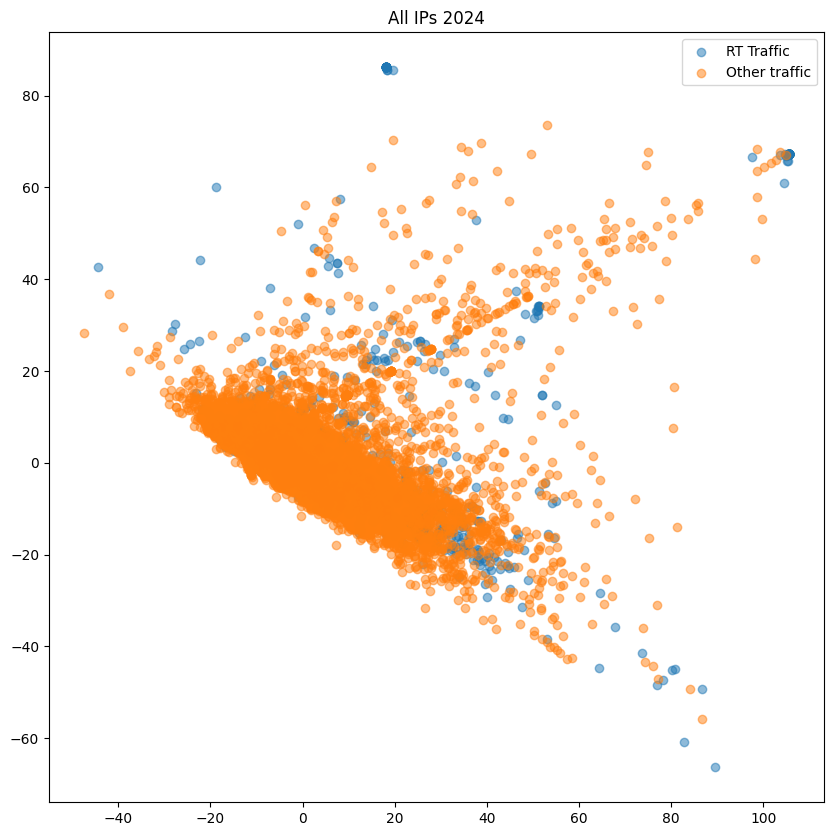

In [132]:
from evaluate_bert import *

visualize_embeddings([rt_embeddings, benign_embeddings], ["RT Traffic", "Other traffic"], "All IPs 2024", "pca") #, x_min=-5, x_max = 30, y_min=-10, y_max=40, alpha=0.5)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

X = np.concatenate([rt_embeddings, benign_embeddings])
y = np.concatenate([np.ones(len(rt_embeddings)), np.zeros(len(benign_embeddings))])

clf = SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X, y, cv=5)

print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

# Optionally, if you want to report other metrics, you can compute them
# by fitting the model on the entire dataset
clf.fit(X, y)
y_pred = clf.predict(X)
print("Overall classification report:")
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      5255
         1.0       0.00      0.00      0.00       214

    accuracy                           0.96      5469
   macro avg       0.48      0.50      0.49      5469
weighted avg       0.92      0.96      0.94      5469



/cluster/raid/home/sosi/repos/Bert/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/raid/home/sosi/repos/Bert/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/raid/home/sosi/repos/Bert/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Cross-validation scores: [0.96891571 0.96562443 0.96836716 0.96544158 0.96781273]
Mean accuracy: 0.9672323208165515


KeyboardInterrupt: 

In [57]:
len(benign_host_host_embeddings)

362660

In [85]:
len(host_embeddings)

5437

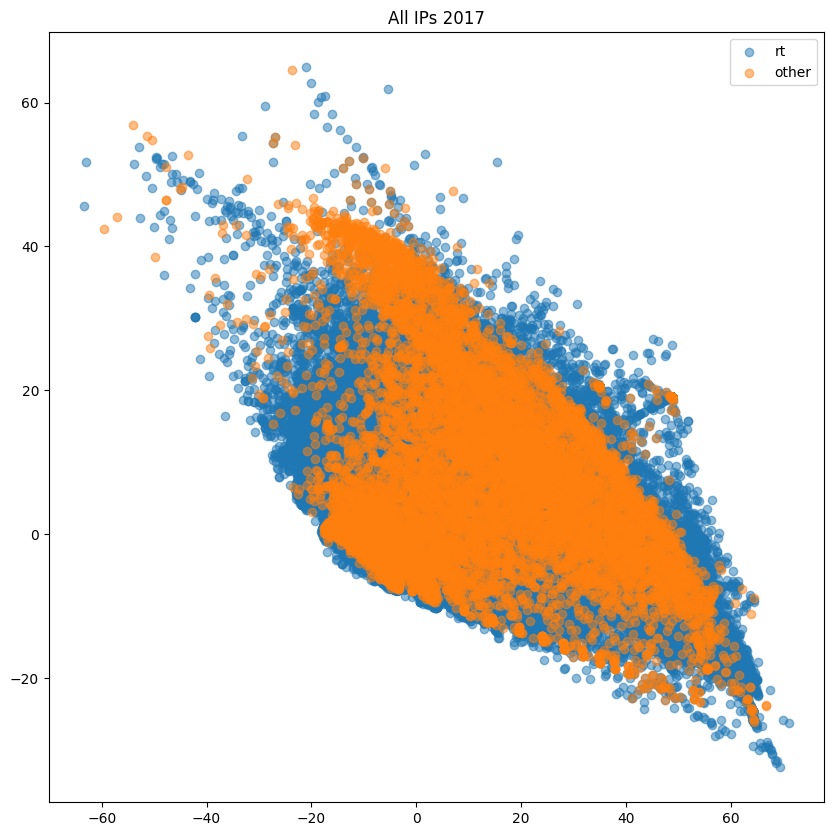

In [134]:
from evaluate_bert import *

visualize_embeddings([benign_host_host_embeddings, rt_host_host_embeddings], ["rt", "other"], "All IPs 2017", "pca")#, x_min=-5, x_max = 30, y_min=-10, y_max=40, alpha=0.5)
